In [6]:
"""
CALCULATE DISTANCES AND ISOCHRONE PARAMETERS FOR SAMPLE OF STARS
Uses Bayesian method applied to spectro-photo-astrom-seismo data, accounting 
for dust
"""
import numpy as np
import pandas as pd
import CalcSpectroPhotoAstromSeismoDistGrid as cspas
import matplotlib.pyplot as plt
import time

### USER-DEFINED PARAMETERS #########################################################
# datafile needs column headings with at least ra and dec, and additionally j, h, k, teff, logg, m_h, mass
# depending on what's available
DATAFILE     = "../results/mock_isochrone_data_nmock100.csv" 
DUST         = False    # whether to correct for extinction
AGEMIN       = 0.5      # minimum age of a star
AGEMAX       = 13.5     # age of universe
USEGALPRIOR  = False    # whether to use galaxy prior    
SOLPOS       = np.array([8.3,0.014,-14.0,12.24+238.,7.25]) # solar position and velocity
PLOTFILE     = "../plots/mock_comp.png"
OUTPUTSFILE  = "../results/outputs_mock.csv" # output file
PARALLEL     = False    # whether to run in parallelized form

## Read data

In [7]:
data     = pd.read_csv(DATAFILE,header=0,index_col=0) 
nstars   = len(data)  
                
print("The number of stars in the sample is:")
print(nstars) 
print(" ")  

The number of stars in the sample is:
100
 


In [22]:
print(data.head())

      modage  modfeh   modmass    moddist      obsl     eobsl      obsb  \
0   3.388442   0.197  1.302243   7.803564  2.186799  0.002185  1.337400   
1  11.748976  -0.056  0.271109  18.114203  0.080689  0.000081  1.450423   
2   3.162278  -0.939  0.511616  10.070987  1.039993  0.001041 -1.549287   
3  12.302688  -0.790  0.534284  13.480925  0.379936  0.000379 -0.210747   
4   6.918310  -0.433  0.264093  17.759319  1.749044  0.001748  0.261604   

      eobsb  obsvarpi  eobsvarpi  ...      obsteff  eobsteff   obslogg  \
0  0.001337  0.128316   0.001281  ...  6102.588963  6.107964  4.109019   
1  0.001449  0.055501   0.000552  ...  3828.275154  3.833008  4.994797   
2  0.001550  0.098428   0.000993  ...  4550.964306  4.548916  4.833794   
3  0.000211  0.074575   0.000742  ...  4602.214342  4.598004  4.772689   
4  0.000261  0.057470   0.000563  ...  3997.220845  4.002965  5.029436   

   eobslogg    obsappJ  eobsappJ    obsappH  eobsappH    obsappK  eobsappK  
0  0.004105  16.874230  0.0

## Define function determining age and distance parameter distributions for a star

In [3]:
# Instantiate class for estimating distances
spas   = cspas.SpectroPhotoAstromSeismoDist(SOLPOS,DUST,AGEMIN,AGEMAX)

 
Undilling isochrones and interpolants...
...done.
 
Calculating weights on galaxy components...
     fbulge = 27344618.563
     fthick = 0.113
     fhalo  = 6.272
...done.


In [8]:
# Define function
def calc_age_dist_mom(jstars):
    
    timestart = time.time()
     
    print("STAR "+str(jstars)+":")
    
    # Print model values
    print("Model age = "+str(data["modage"][jstars])+" Gyr.")
    print("Model [Fe/H] = "+str(data["modfeh"][jstars])+" dex.")
    print("Model mass = "+str(data["modmass"][jstars])+" Msun.")
    print("Model distance modulus = "+str(5.+5.*np.log10(data["moddist"][jstars]))+" mag.")
    print("Model logg = "+str(data["obslogg"][jstars])+" dex.")
    print("Model teff = "+str(data["obsteff"][jstars])+" K.")
    print(" ")   
    
    # Calculate Galactic longitude and latitude
    obsl = np.copy(data["obsl"][jstars]) # rad
    obsb = np.copy(data["obsb"][jstars]) # rad
    
    # Coordinates of star
    obsStarDict = {'varpi': [data["obsvarpi"][jstars], data["eobsvarpi"][jstars]], 
                   'mh':    [data["obsfeh"][jstars], data["eobsfeh"][jstars]],
                   'mass':  [data["obsmass"][jstars], data["eobsmass"][jstars]],
                   'teff':  [data["obsteff"][jstars], data["eobsteff"][jstars]],
                   'logg':  [data["obslogg"][jstars], data["eobslogg"][jstars]],
                   'jmag':  [data["obsappJ"][jstars], data["eobsappJ"][jstars]],
                   'hmag':  [data["obsappH"][jstars], data["eobsappH"][jstars]],
                   'kmag':  [data["obsappK"][jstars], data["eobsappK"][jstars]]}
    obsStar   = pd.DataFrame(data=obsStarDict) 
    obsvarpi  = obsStar["varpi"][0]
    eobsvarpi = obsStar["varpi"][1]
              
    # Calculate grid of posterior probabilities
    nsig         = 5.
    nmass        = 100
    ns           = 100
    varpimin     = obsvarpi-nsig*eobsvarpi
    if (varpimin<0.):
        varpimin = 0.001
    varpimax     = obsvarpi+nsig*eobsvarpi
    varpigrid    = np.linspace(varpimin,varpimax,ns)
    sgrid        = 1./varpigrid
    sgrid        = np.sort(sgrid)
    
    # Calculate posterior grid
    log10agepost,mhpost,log10masspost,dmpost,loggpost,teffpost,lnppost = \
        spas.pPostGrid(obsStar,obsl,obsb,nsig,nmass,sgrid,USEGALPRIOR)
        
    # Estimate maximum posterior solution
    best_post_soln_dict = spas.estMaxPost(log10agepost,mhpost,log10masspost,dmpost,loggpost,teffpost,lnppost)
    print("Max posterior age = "+str(10.**best_post_soln_dict["log10age_best"])+" Gyr.")
    print("Max posterior [Fe/H] = "+str(best_post_soln_dict["mh_best"])+" dex.")
    print("Max posterior mass = "+str(10.**best_post_soln_dict["log10mass_best"])+" Msun.")
    print("Max posterior distance modulus = "+str(best_post_soln_dict["dm_best"])+" mag.")
    print("Max posterior logg = "+str(best_post_soln_dict["logg_best"])+" dex.")
    print("Max posterior teff = "+str(best_post_soln_dict["teff_best"])+" K.")
    print(" ")
    
    # Calculate moments 
    which_moments_dict = {"mh":   True, 
                          "mass": True, 
                          "dm":   True, 
                          "logg": True,
                          "teff": True}
    moments_dict = spas.calcMoments(log10agepost,mhpost,log10masspost,dmpost,loggpost,teffpost,lnppost,which_moments_dict)

    log10age_mu   = moments_dict["log10age_mu"]
    log10age_std  = moments_dict["log10age_std"]
    age_mu        = 10.**log10age_mu
    age_std       = (10.**(log10age_mu + log10age_std) - 10.**(log10age_mu - log10age_std))/2.
    log10mass_mu  = moments_dict["log10mass_mu"]
    log10mass_std = moments_dict["log10mass_std"]
    mass_mu       = 10.**log10mass_mu
    mass_std      = (10.**(log10mass_mu + log10mass_std) - 10.**(log10mass_mu - log10mass_std))/2.

    # Print moment solutions
    print("Moment age +/ error (Gyr): "+str(age_mu)+" +/- "+str(age_std))
    print("Moment [Fe/H] +/ error (dex): "+str(moments_dict["mh_mu"])+" +/- "+str(moments_dict["mh_std"]))
    print("Moment mass +/ error (Msun): "+str(mass_mu)+" +/- "+str(mass_std))
    print("Moment distance modulus +/ error (mag): "+str(moments_dict["dm_mu"])+" +/- "+str(moments_dict["dm_std"]))
    print("Moment logg +/ error (dex): "+str(moments_dict["logg_mu"])+" +/- "+str(moments_dict["logg_std"]))
    print("Moment teff +/ error (K): "+str(moments_dict["teff_mu"])+" +/- "+str(moments_dict["teff_std"]))
    print(" ")
    
    timeend   = time.time()
    timetaken = timeend-timestart
    print("Run took "+ str(timetaken) + "s.")
    print(" ") 
    
    outputs_dict = best_post_soln_dict.copy()
    outputs_dict.update(moments_dict)

    return(outputs_dict)

## Determine age and distance parameter distributions for all stars

In [9]:
# Run
if (PARALLEL):
    timestart = time.time()
    num_cores = 1
    pool      = Pool(processes=num_cores)
    res       = pool.map(calc_age_dist_mom, range(nstars))
    pool.close() 
    timeend   = time.time()
    timetaken = timeend-timestart
    print("Run took "+ str(timetaken) + "s.")
    print(" ") 
else:
    res = map(calc_age_dist_mom, range(nstars))

# Save to array
outputs = np.zeros([nstars,18])
jstars  = 0
for resstar in res:
    outputs[jstars,:] = np.array([resstar["log10age_best"],resstar["mh_best"],resstar["log10mass_best"],resstar["dm_best"],\
                                  resstar["logg_best"],resstar["teff_best"],resstar["log10age_mu"],resstar["mh_mu"],\
                                  resstar["log10mass_mu"],resstar["dm_mu"],resstar["logg_mu"],resstar["teff_mu"],\
                                  resstar["log10age_std"],resstar["mh_std"],resstar["log10mass_std"],resstar["dm_std"],\
                                  resstar["logg_std"],resstar["teff_std"]])
                             
    jstars +=1

STAR 0:
Model age = 3.3884415613920207 Gyr.
Model [Fe/H] = 0.197 dex.
Model mass = 1.3022434880532594 Msun.
Model distance modulus = 9.461464860602806 mag.
Model logg = 4.109019315196594 dex.
Model teff = 6102.588962882785 K.
 
Max posterior age = 3.3884415613920207 Gyr.
Max posterior [Fe/H] = 0.197 dex.
Max posterior mass = 1.303945280000105 Msun.
Max posterior distance modulus = 14.470673535051294 mag.
Max posterior logg = 4.10180115336152 dex.
Max posterior teff = 6105.316486910152 K.
 
Moment age +/ error (Gyr): 3.4182212451025364 +/- 0.03820466880601381
Moment [Fe/H] +/ error (dex): 0.19699999999999998 +/- 3.725290298461914e-09
Moment mass +/ error (Msun): 1.2990018419425864 +/- 0.00630223137963315
Moment distance modulus +/ error (mag): 14.454642369643656 +/- 0.020609106622354635
Moment logg +/ error (dex): 4.106225173747459 +/- nan
Moment teff +/ error (K): 6100.975705523416 +/- 5.544423567688518
 
Run took 7.4786295890808105s.
 
STAR 1:
Model age = 11.748975549395254 Gyr.
Model

/home/payel/Dropbox/ResearchProjects/shared/python/ParsecIsochronesAgeDistance/python/CalcSpectroPhotoAstromSeismoDistGrid.py:664: RuntimeWarning: invalid value encountered in sqrt
  log10mass_std = np.sqrt(log10mass_2-log10mass_mu**2.)


Moment age +/ error (Gyr): 11.748975549395254 +/- 0.0
Moment [Fe/H] +/ error (dex): -0.5829999999999999 +/- 7.450580596923828e-09
Moment mass +/ error (Msun): 0.847648414353077 +/- nan
Moment distance modulus +/ error (mag): 13.879475288898103 +/- 0.0009109525574666703
Moment logg +/ error (dex): 1.240232918537608 +/- nan
Moment teff +/ error (K): 4133.734798366469 +/- 6.103515625e-05
 
Run took 8.266579866409302s.
 
STAR 7:
Model age = 7.244359600749891 Gyr.
Model [Fe/H] = -0.583 dex.
Model mass = 0.5837852262061664 Msun.
Model distance modulus = 7.8031805188296754 mag.
Model logg = 4.72992900469285 dex.
Model teff = 4617.92066099634 K.
 
Max posterior age = 5.011872336272715 Gyr.
Max posterior [Fe/H] = -0.583 dex.
Max posterior mass = 0.5894357544172025 Msun.
Max posterior distance modulus = 12.797094578590665 mag.
Max posterior logg = 4.72959534052623 dex.
Max posterior teff = 4623.282310555688 K.
 
Moment age +/ error (Gyr): 4.28041494428262 +/- 1.3899783542123363
Moment [Fe/H] +/ 

/home/payel/Dropbox/ResearchProjects/shared/python/ParsecIsochronesAgeDistance/python/CalcSpectroPhotoAstromSeismoDistGrid.py:685: RuntimeWarning: invalid value encountered in sqrt
  teff_std      = np.sqrt(teff_2-teff_mu**2.)


Moment age +/ error (Gyr): 2.3442288153199176 +/- 0.0
Moment [Fe/H] +/ error (dex): -0.48499999999999993 +/- 5.268356063861754e-09
Moment mass +/ error (Msun): 1.45035 +/- 6.220404524803769e-09
Moment distance modulus +/ error (mag): 14.31546528672521 +/- 0.0012636313572712194
Moment logg +/ error (dex): 2.449249999999857 +/- nan
Moment teff +/ error (K): 4972.788632333814 +/- nan
 
Run took 7.942066669464111s.
 
STAR 74:
Model age = 10.71519305237605 Gyr.
Model [Fe/H] = -0.485 dex.
Model mass = 0.6641282585505873 Msun.
Model distance modulus = 1.2767662601695937 mag.
Model logg = 4.62993833369819 dex.
Model teff = 4999.460474030993 K.
 
Max posterior age = 10.715193052376048 Gyr.
Max posterior [Fe/H] = -0.485 dex.
Max posterior mass = 0.6641793130159521 Msun.
Max posterior distance modulus = 6.278352591010835 mag.
Max posterior logg = 4.6283541161739645 dex.
Max posterior teff = 5008.80832803524 K.
 
Moment age +/ error (Gyr): 10.2754321796464 +/- 0.6838917640150282
Moment [Fe/H] +/ e

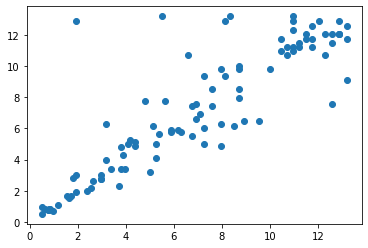

In [10]:
plt.scatter(data["modage"],10.**outputs[:,0])

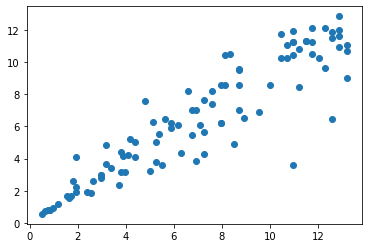

In [12]:
plt.scatter(data["modage"],10.**outputs[:,6])

/home/payel/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


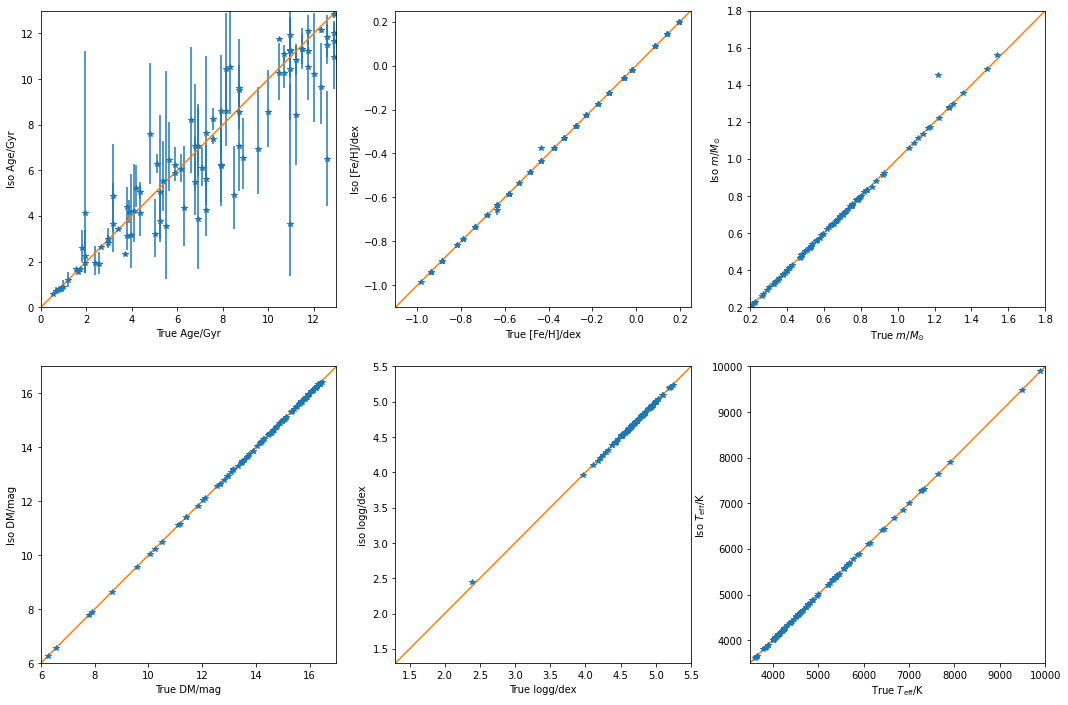

In [36]:
# Plot recovered ages against input ages
fig, ax = plt.subplots(2,3,figsize=(18,12))

age_mu  = 10.**outputs[:,6]
age_std = np.array([age_mu - 10.**(outputs[:,6]-outputs[:,12]),10.**(outputs[:,6] + outputs[:,12])-age_mu])
agemin  = 0.
agemax  = 13.
ax[0,0].errorbar(data["modage"],age_mu,yerr=age_std,linestyle="None",fmt="*")
ax[0,0].set_xlim([agemin,agemax])
ax[0,0].set_ylim([agemin,agemax])
ax[0,0].plot([agemin,agemax],[agemin,agemax])
ax[0,0].set_xlabel("True Age/Gyr")
ax[0,0].set_ylabel("Iso Age/Gyr")

fehmin  = -1.1
fehmax  = 0.25
ax[0,1].errorbar(data["modfeh"],outputs[:,7],yerr=outputs[:,13],linestyle="None",fmt="*")
ax[0,1].set_xlim([fehmin,fehmax])
ax[0,1].set_ylim([fehmin,fehmax])
ax[0,1].plot([fehmin,fehmax],[fehmin,fehmax])
ax[0,1].set_xlabel("True [Fe/H]/dex")
ax[0,1].set_ylabel("Iso [Fe/H]/dex")

mass_mu  = 10.**outputs[:,8]
mass_std = np.array([mass_mu - 10.**(outputs[:,8]-outputs[:,14]),10.**(outputs[:,8] + outputs[:,14])-mass_mu])
massmin  = 0.2
massmax  = 1.8
ax[0,2].errorbar(data["modmass"],mass_mu,yerr=mass_std,linestyle="None",fmt="*")
ax[0,2].set_xlim([massmin,massmax])
ax[0,2].set_ylim([massmin,massmax])
ax[0,2].plot([massmin,massmax],[massmin,massmax])
ax[0,2].set_xlabel(r"True $m/M_{\odot}$")
ax[0,2].set_ylabel(r"Iso $m/M_{\odot}$")

dmmin  = 6.
dmmax  = 17.
ax[1,0].errorbar(5.*np.log10(data["moddist"]*1000.)-5.,outputs[:,9],yerr=outputs[:,15],linestyle="None",fmt="*")
ax[1,0].set_xlim([dmmin,dmmax])
ax[1,0].set_ylim([dmmin,dmmax])
ax[1,0].plot([dmmin,dmmax],[dmmin,dmmax])
ax[1,0].set_xlabel("True DM/mag")
ax[1,0].set_ylabel("Iso DM/mag")

loggmin  = 1.3
loggmax  = 5.5
ax[1,1].errorbar(data["obslogg"],outputs[:,10],yerr=outputs[:,16],linestyle="None",fmt="*")
ax[1,1].set_xlim([loggmin,loggmax])
ax[1,1].set_ylim([loggmin,loggmax])
ax[1,1].plot([loggmin,loggmax],[loggmin,loggmax])
ax[1,1].set_xlabel("True logg/dex")
ax[1,1].set_ylabel("iso logg/dex")

teffmin  = 3500.
teffmax  = 10000.
ax[1,2].errorbar(data["obsteff"],outputs[:,11],yerr=outputs[:,17],linestyle="None",fmt="*")
ax[1,2].set_xlim([teffmin,teffmax])
ax[1,2].set_ylim([teffmin,teffmax])
ax[1,2].plot([teffmin,teffmax],[teffmin,teffmax])
ax[1,2].set_xlabel(r"True $T_{\mathrm{eff}}$/K")
ax[1,2].set_ylabel(r"Iso $T_{\mathrm{eff}}$/K")

plt.savefig(PLOTFILE,format="png")

In [38]:
# Save outputs to file
outputsDF = pd.DataFrame(outputs,columns=["log10age_best","mh_best","log10mass_best","dm_best",\
                                          "logg_best","teff_best","log10age_mu","mh_mu",\
                                          "log10mass_mu","dm_mu","logg_mu","teff_mu","log10age_std",
                                          "mh_std","log10mass_std","dm_std","logg_std","teff_std"])
outputsDF.to_csv(OUTPUTSFILE)